<a href="https://colab.research.google.com/github/LEEINSEO-0118/HD_AI_Challenge/blob/main/HD_AI_Challenge_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

file_path = '/content/drive/MyDrive/ai부트캠프/Machine_Learning/DATA/HD_challenge/'
train = pd.read_csv(file_path+'train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv(file_path+'test.csv').drop(columns=['SAMPLE_ID'])

## datetime 컬럼 처리

In [3]:
# datetime 컬럼 처리
train.ATA = pd.to_datetime(train['ATA'])
test.ATA = pd.to_datetime(train['ATA'])

# datetime 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

## Categorical feature encoding

In [4]:
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc = 'Encoding features'):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


## 결측치 처리

결측치를 means으로 대충 채운 경우 [U_WIND, V_WIND, AIR_TEMPERATURE, BN] 피쳐들의 중요도가 낮게 나옴.  
*MAE = 53.45077523955608*

결측치를 다 없애고. origin한 데이터로 예측을 하는 경우에도 중요도는 유사함


In [5]:
train.fillna(train.mean(),inplace= True)
test.fillna(train.mean(), inplace=True)

In [6]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

## 모델 학습, feature importance 확인

Model Tune for LGBM
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


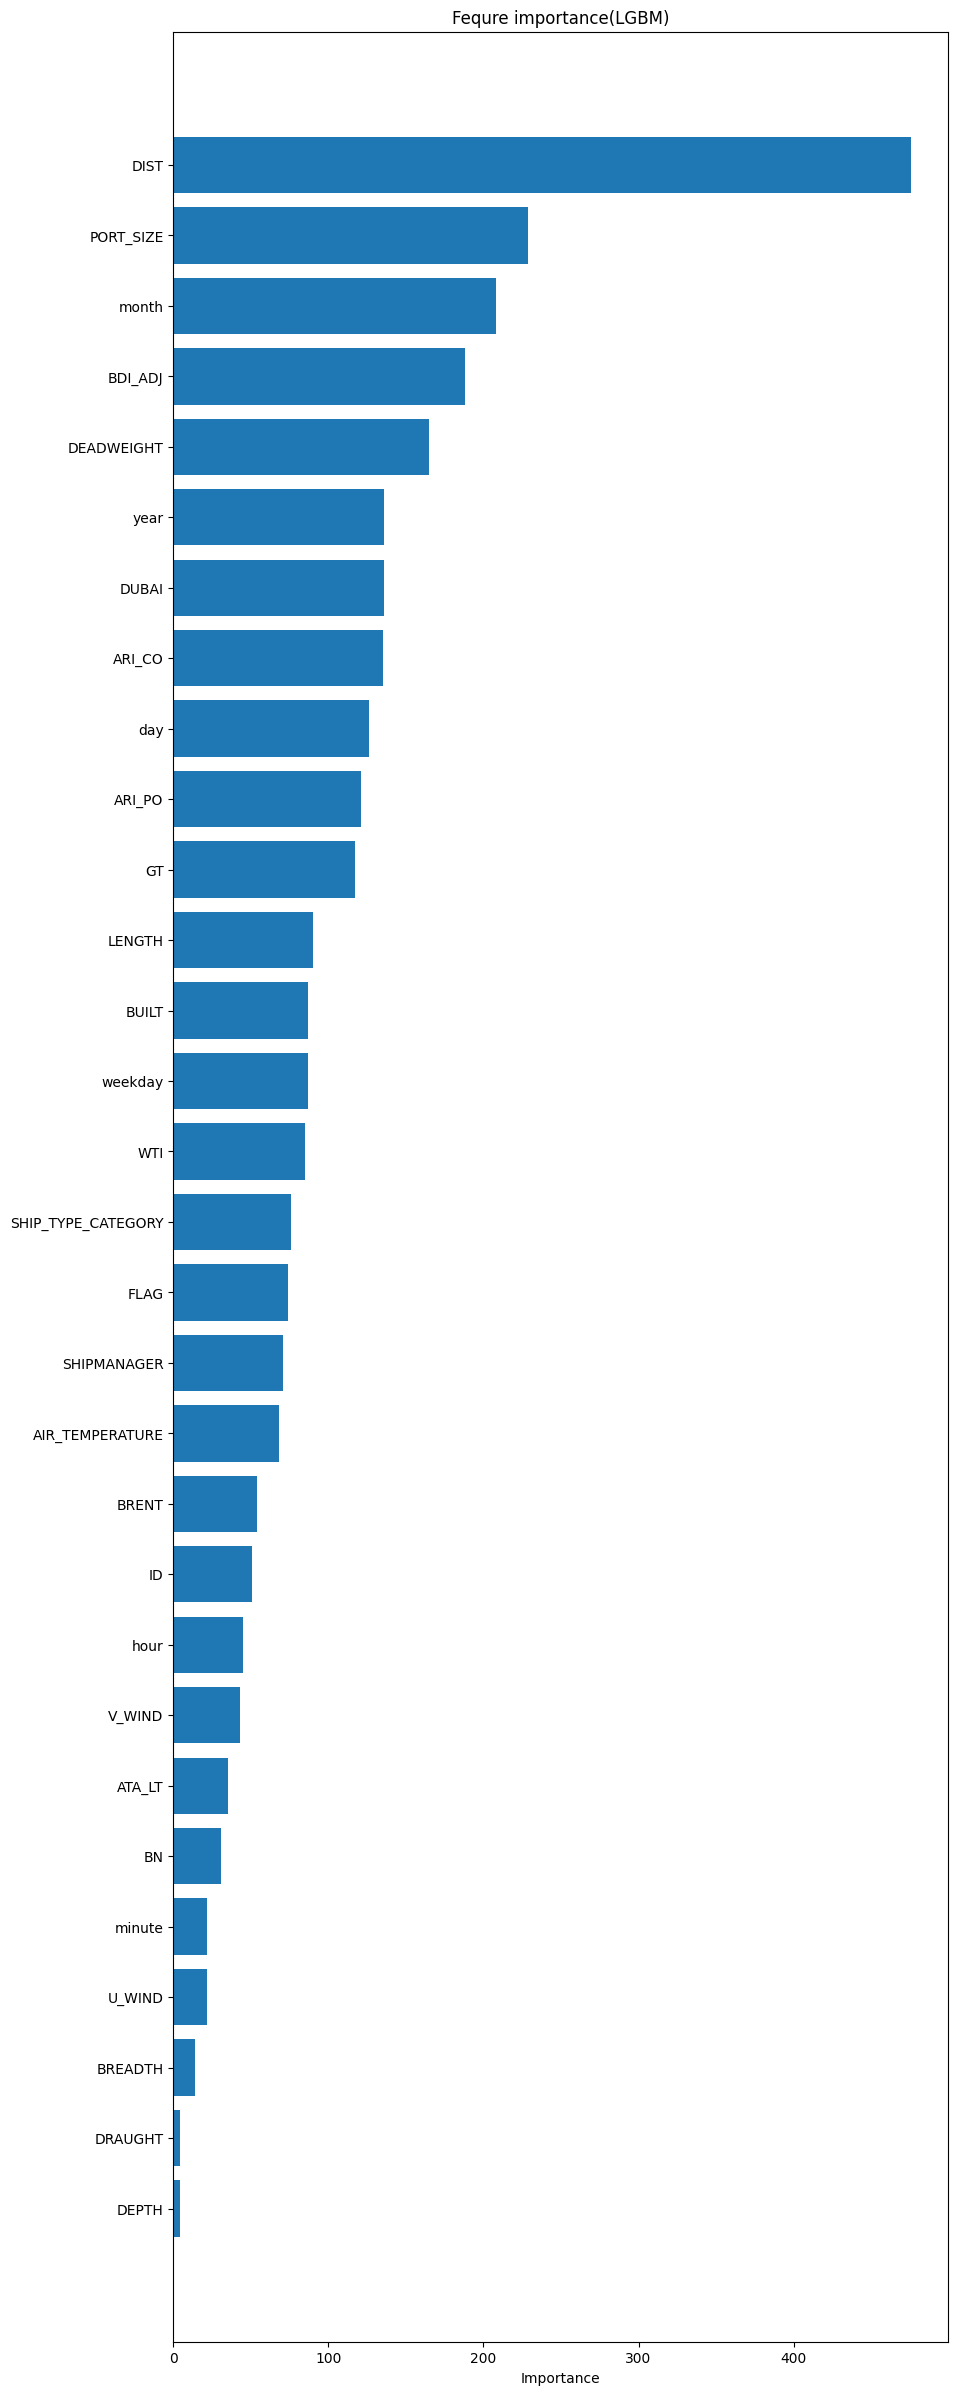

In [7]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize = (10, len(X_train.columns)))
    plt.title(f'Fequre importance({model_name})')
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns = 'CI_HOUR')
y_train = train.CI_HOUR

lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM'
                                                            , X_train, y_train)

In [8]:
threshold = 85
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [9]:
!pip install lightgbm optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.3 MB/s eta 0:00:00


In [10]:
params = {'n_estimators' : 500, 'learning_rate': 0.16, 'max_depth': 25, 'num_leaves': 512,
          'min_child_samples' : 50, 'colsample_bytree' : 0.8}

lgbm = lgb.LGBMRegressor(**params, random_state = 42)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [01:30<06:00, 90.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [02:51<04:14, 84.76s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [04:13<02:47, 83.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [05:35<01:23, 83.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [06:56<00:00, 83.33s/it]

Validation : MAE scores for each fold: [30.843265895947486, 31.422270564696085, 31.68424994752263, 31.266728212572435, 31.101892131818175]
Validation : MAE: 31.263681350511366


In [11]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    # template
    # num_leaves = trial.suggest_categorical('num_leaves', []) # Grid search의 방법
    # max_depth = trial.suggest_int('max_depth', low, high)
    # learning_rate = trial.suggest_float('learning_rate', low, high)
    num_leaves = trial.suggest_categorical('num_leaves', [128, 256, 512]) # Grid search의 방법
    max_depth = trial.suggest_int('max_depth', 10, 25)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 100)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8)


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = lgb.LGBMRegressor(num_leaves = num_leaves,
                              max_depth = max_depth,
                              learning_rate = learning_rate,
                              n_estimators = n_estimators,
                              min_child_samples = min_child_samples,
                              colsample_bytree = colsample_bytree,
                              random_state = 42)


    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
from functools import partial

K = 5   # Kfold 수
opt_func = partial(optimizer, X=X_train_reduced, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=50) # 50정도의 시행횟수를 추천함.

[I 2023-10-10 14:37:20,037] A new study created in memory with name: no-name-e170e825-7859-40ff-b4b1-75f4744735af


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in 

[I 2023-10-10 14:39:15,667] Trial 0 finished with value: 32.41418144358808 and parameters: {'num_leaves': 256, 'max_depth': 22, 'learning_rate': 0.20064432589996076, 'n_estimators': 461, 'min_child_samples': 52, 'colsample_bytree': 0.657206113728951}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2023-10-10 14:40:13,899] Trial 1 finished with value: 35.56468103078288 and parameters: {'num_leaves': 512, 'max_depth': 18, 'learning_rate': 0.21049535657280039, 'n_estimators': 164, 'min_child_samples': 49, 'colsample_bytree': 0.6187421396188139}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:42:15,606] Trial 2 finished with value: 33.61779229104942 and parameters: {'num_leaves': 512, 'max_depth': 25, 'learning_rate': 0.21088679450842257, 'n_estimators': 355, 'min_child_samples': 64, 'colsample_bytree': 0.5701276884384243}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:43:15,034] Trial 3 finished with value: 33.198715944491724 and parameters: {'num_leaves': 128, 'max_depth': 15, 'learning_rate': 0.2278397686121757, 'n_estimators': 374, 'min_child_samples': 34, 'colsample_bytree': 0.7483964005172116}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:43:53,589] Trial 4 finished with value: 53.206868108519316 and parameters: {'num_leaves': 128, 'max_depth': 16, 'learning_rate': 0.030475722335435433, 'n_estimators': 173, 'min_child_samples': 74, 'colsample_bytree': 0.5291122651865068}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:45:14,006] Trial 5 finished with value: 33.024559949473215 and parameters: {'num_leaves': 256, 'max_depth': 19, 'learning_rate': 0.16758761291144933, 'n_estimators': 430, 'min_child_samples': 11, 'colsample_bytree': 0.5547260419385055}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041101 seconds.
You can set `force_col_wise=true` to remove the o

[I 2023-10-10 14:47:11,552] Trial 6 finished with value: 34.06230186926541 and parameters: {'num_leaves': 512, 'max_depth': 24, 'learning_rate': 0.14450007146923216, 'n_estimators': 321, 'min_child_samples': 81, 'colsample_bytree': 0.5411529433537734}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:47:25,985] Trial 7 finished with value: 47.1083107088315 and parameters: {'num_leaves': 128, 'max_depth': 16, 'learning_rate': 0.22435841243084811, 'n_estimators': 51, 'min_child_samples': 91, 'colsample_bytree': 0.7063517031690573}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:48:22,807] Trial 8 finished with value: 43.01475941237605 and parameters: {'num_leaves': 128, 'max_depth': 22, 'learning_rate': 0.05576685125224577, 'n_estimators': 311, 'min_child_samples': 46, 'colsample_bytree': 0.6591930515908095}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2023-10-10 14:48:45,527] Trial 9 finished with value: 53.0044359417207 and parameters: {'num_leaves': 512, 'max_depth': 10, 'learning_rate': 0.08815810910018407, 'n_estimators': 61, 'min_child_samples': 64, 'colsample_bytree': 0.7227585165228847}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:50:18,852] Trial 10 finished with value: 32.446393240246735 and parameters: {'num_leaves': 256, 'max_depth': 21, 'learning_rate': 0.26525331597087937, 'n_estimators': 491, 'min_child_samples': 23, 'colsample_bytree': 0.7996739415919697}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:51:51,766] Trial 11 finished with value: 32.59502304264929 and parameters: {'num_leaves': 256, 'max_depth': 21, 'learning_rate': 0.28672717129912395, 'n_estimators': 500, 'min_child_samples': 19, 'colsample_bytree': 0.7893446873849992}. Best is trial 0 with value: 32.41418144358808.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:53:26,890] Trial 12 finished with value: 32.121394787327574 and parameters: {'num_leaves': 256, 'max_depth': 21, 'learning_rate': 0.27741906830699437, 'n_estimators': 498, 'min_child_samples': 26, 'colsample_bytree': 0.7942067465873648}. Best is trial 12 with value: 32.121394787327574.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:54:49,056] Trial 13 finished with value: 34.21264637198756 and parameters: {'num_leaves': 256, 'max_depth': 23, 'learning_rate': 0.2983010879421756, 'n_estimators': 432, 'min_child_samples': 35, 'colsample_bytree': 0.6715063171805732}. Best is trial 12 with value: 32.121394787327574.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[I 2023-10-10 14:56:02,533] Trial 14 finished with value: 33.24119657147297 and parameters: {'num_leaves': 256, 'max_depth': 20, 'learning_rate': 0.2666783414042515, 'n_estimators': 421, 'min_child_samples': 3, 'colsample_bytree': 0.6103625445423008}. Best is trial 12 with value: 32.121394787327574.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in 

[I 2023-10-10 14:57:01,812] Trial 15 finished with value: 35.403529968121575 and parameters: {'num_leaves': 256, 'max_depth': 13, 'learning_rate': 0.16351958022329177, 'n_estimators': 243, 'min_child_samples': 37, 'colsample_bytree': 0.5012710772991329}. Best is trial 12 with value: 32.121394787327574.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 14:58:45,135] Trial 16 finished with value: 32.18732948412442 and parameters: {'num_leaves': 256, 'max_depth': 23, 'learning_rate': 0.24520938904173645, 'n_estimators': 454, 'min_child_samples': 59, 'colsample_bytree': 0.7502345659126138}. Best is trial 12 with value: 32.121394787327574.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:00:12,241] Trial 17 finished with value: 32.74891797349352 and parameters: {'num_leaves': 256, 'max_depth': 25, 'learning_rate': 0.2571698636837761, 'n_estimators': 385, 'min_child_samples': 60, 'colsample_bytree': 0.7576872171888644}. Best is trial 12 with value: 32.121394787327574.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070673 seconds.
You can set `force_col_wise=true` to remove the o

[I 2023-10-10 15:01:20,171] Trial 18 finished with value: 33.520058317395396 and parameters: {'num_leaves': 256, 'max_depth': 19, 'learning_rate': 0.29782044414468123, 'n_estimators': 248, 'min_child_samples': 96, 'colsample_bytree': 0.7718130311718182}. Best is trial 12 with value: 32.121394787327574.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:02:49,034] Trial 19 finished with value: 31.696385146173764 and parameters: {'num_leaves': 256, 'max_depth': 23, 'learning_rate': 0.24278121837449979, 'n_estimators': 466, 'min_child_samples': 23, 'colsample_bytree': 0.7197112749408942}. Best is trial 19 with value: 31.696385146173764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:04:03,999] Trial 20 finished with value: 32.41716644274914 and parameters: {'num_leaves': 256, 'max_depth': 20, 'learning_rate': 0.24421061898935853, 'n_estimators': 388, 'min_child_samples': 22, 'colsample_bytree': 0.7083979136747898}. Best is trial 19 with value: 31.696385146173764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:05:37,298] Trial 21 finished with value: 32.126986278738094 and parameters: {'num_leaves': 256, 'max_depth': 23, 'learning_rate': 0.2474510225489999, 'n_estimators': 464, 'min_child_samples': 29, 'colsample_bytree': 0.7422760863265953}. Best is trial 19 with value: 31.696385146173764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in 

[I 2023-10-10 15:07:12,492] Trial 22 finished with value: 32.153189630276884 and parameters: {'num_leaves': 256, 'max_depth': 23, 'learning_rate': 0.27039921224309743, 'n_estimators': 496, 'min_child_samples': 27, 'colsample_bytree': 0.7300907916992163}. Best is trial 19 with value: 31.696385146173764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:08:35,625] Trial 23 finished with value: 31.76768627399805 and parameters: {'num_leaves': 256, 'max_depth': 24, 'learning_rate': 0.24179863854586345, 'n_estimators': 464, 'min_child_samples': 11, 'colsample_bytree': 0.7744154779210952}. Best is trial 19 with value: 31.696385146173764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:09:50,955] Trial 24 finished with value: 31.207129495211422 and parameters: {'num_leaves': 256, 'max_depth': 25, 'learning_rate': 0.27748454068376865, 'n_estimators': 409, 'min_child_samples': 1, 'colsample_bytree': 0.7818027446517477}. Best is trial 24 with value: 31.207129495211422.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:11:07,147] Trial 25 finished with value: 31.697936074878196 and parameters: {'num_leaves': 256, 'max_depth': 25, 'learning_rate': 0.19256330645651135, 'n_estimators': 403, 'min_child_samples': 4, 'colsample_bytree': 0.7731053703262122}. Best is trial 24 with value: 31.207129495211422.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:12:16,861] Trial 26 finished with value: 31.872459305476895 and parameters: {'num_leaves': 256, 'max_depth': 25, 'learning_rate': 0.18623431589831918, 'n_estimators': 346, 'min_child_samples': 1, 'colsample_bytree': 0.7722809911696389}. Best is trial 24 with value: 31.207129495211422.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:13:31,934] Trial 27 finished with value: 32.18068443011222 and parameters: {'num_leaves': 256, 'max_depth': 25, 'learning_rate': 0.1870745220729437, 'n_estimators': 406, 'min_child_samples': 11, 'colsample_bytree': 0.6972349816636375}. Best is trial 24 with value: 31.207129495211422.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:14:16,594] Trial 28 finished with value: 37.56985116957201 and parameters: {'num_leaves': 128, 'max_depth': 24, 'learning_rate': 0.13729414783901586, 'n_estimators': 284, 'min_child_samples': 14, 'colsample_bytree': 0.7262837785002633}. Best is trial 24 with value: 31.207129495211422.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [I

[I 2023-10-10 15:15:40,403] Trial 29 finished with value: 32.55722845024172 and parameters: {'num_leaves': 512, 'max_depth': 22, 'learning_rate': 0.22570269607738924, 'n_estimators': 341, 'min_child_samples': 5, 'colsample_bytree': 0.7599783430633107}. Best is trial 24 with value: 31.207129495211422.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.807473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 62.051334


In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

## 파라미터에따른 MAE 변화  
설정을 하지 않았을 떄 MAE = 53.45077523955608  
{'num_leaves': 256, 'max_depth': 15, 'learning_rate': 0.3, 'colsample_bytree' : 0.8}일 때 MAE = 36.97465414001219

{'num_leaves': 512, 'max_depth': 25, 'learning_rate': 0.16,'colsample_bytree' : 0.8, 'n_estimators' : 500}일 때 MAE = 30 -> Dacon Leader Board 기준 28.504

## Submission

In [ ]:
best_params = study.best_params
best_model = lgb.LGBMRegressor(**best_params,
                           random_state = 42)

# model finalization : 가장 좋은 성능을 보인 모델로, 전체 데이터 트레이닝
best_model.fit(X_train_reduced, y_train)
preds = best_model.predict(X_test_reduced)
preds

In [ ]:
submission = pd.read_csv(file_path + 'sample_submission.csv')
submission['answer'] = preds
submission.to_csv(file_path + "submission.csv", index=False)
submission